In [1]:
import jax
import jax.numpy as jnp

import itertools
import time

import functools
from copy import deepcopy
import matplotlib.pyplot as plt

class MeasureTime:
    def __init__(self, func):
        self.func = func
        self.time_taken = None

    def __call__(self, *args, **kwargs):
        start_time = time.perf_counter()
        result = self.func(*args, **kwargs)
        self.time_taken = time.perf_counter() - start_time
        return result

    @property
    def time(self):
        return self.time_taken

class MeanFieldSolver:
    def __init__(self, V, U):
        self.U = U
        self.U_vmap = jax.jit(jax.vmap(U, in_axes = (None, 0, None)))
        self.V = V

    def solve(self, rho0, T, J, key = None, dt=1.0):
        start = time.time()
        # define Psi
        @jax.jit
        def Psi(theta, rho, key):
            # compute t1
            key, subkey = jax.random.split(key)
            t1 = self.V(theta, key)

            # compute t2
            t2 = self.U_vmap(theta, rho, subkey).mean()
            return t1 + t2
        
        grad_psi = jax.jit(jax.grad(Psi))
        grad_psi_vmap = jax.jit(jax.vmap(grad_psi, in_axes=(0, None, None)))
        
        if key is None:
            key = jax.random.key(123)
        
        rho = deepcopy(rho0)

        t_c = 0.0
        self.checkpoints = [(0, deepcopy(rho))]
            
        while t_c < T:
            if int(t_c) > self.checkpoints[-1][0]: 
                self.checkpoints.append([t_c, deepcopy(rho)])
            key, subkey = jax.random.split(key)
            grads = grad_psi_vmap(rho, rho, subkey)
            for a in grads.keys():
                rho[a] += dt * (-grads[a])
            t_c += dt
        
        end = time.time()
        
        self.elapsed = end-start

In [22]:
# problem specification
P = 3
lst = [[[-1],[1]] for p in range(P)]
xavg = jnp.array(list(itertools.product(*lst)), dtype=jnp.float32)

parities = [list(range(i+1)) for i in range(P)]

# create target function and Psi here
@jax.jit
def h(x):
    res = 0.0
    for s in parities:
        prod = 1.0
        for i in s:
            prod *= x[i]
        res += prod
    return res

h_vmap = jax.jit(jax.vmap(h))
test = h_vmap(xavg) # force jit the function

@jax.jit
def sigma(x, shift = 0.5):
    return 1.0/ (1.0 + jnp.exp(-x + shift))

@jax.jit
def neuron(x, p, key, num_samples = 1000):
    g = jax.random.normal(key, (num_samples,))
    
    # (hidden_size, num_samples)
    outs = p['L'] * sigma(jnp.dot(p['W'], x) + g * p['S'])
    return outs.mean(axis=0)

neuron_vmap = jax.vmap(neuron, in_axes=(0, None, None))

@jax.jit
def U(p1, p2, key):
    key, subkey = jax.random.split(key)
    t1 = neuron_vmap(xavg, p1, key) # (2**P, 0)
    t2 = neuron_vmap(xavg, p2, subkey) # (2**P, 0)
    return (t1 * t2).mean(axis=0)

def V(p, key):
    t1 = neuron_vmap(xavg, p, key)
    t2 = h_vmap(xavg)[:, 0]
    return -(t1 * t2).mean(axis=0)

In [17]:
seed = 123
key = jax.random.key(seed)

J = 20

W = jnp.zeros((J, P))
S = jnp.ones((J, 1))

key, subkey = jax.random.split(key)
l = jax.random.uniform(subkey,  (J, 1), minval=-1, maxval=1)

rho0 = {'W' : W, 'S' : S, 'L': l}

T = 3000
dt = 0.05

key, subkey = jax.random.split(key)

solver = MeanFieldSolver(V, U)
solver.solve(rho0, T, J, subkey, dt)
print(f"Solver took {solver.elapsed}s")

Solver took 79.7129499912262s


In [18]:
# to compute the fourier coefficients
def chi(x, idxs):
    prod = 1.0
    for i in idxs:
        prod *= x[i]
    return prod

@jax.jit
def net(x, rho, key, num_samples = 1000):
    J = rho['W'].shape[0]
    g = jax.random.normal(key, (num_samples,))
    R = rho['W'] @ x
    out = rho['L'].T @ sigma(R + rho['S'] * g).mean(axis=1)/J
    return out

characteristics = [(idxs, lambda x, idxs=idxs: chi(x, idxs)) for idxs in parities]
characteristics = [(idx, jax.jit(jax.vmap(fn))) for (idx, fn) in characteristics]
net_vmap = jax.jit(jax.vmap(net, in_axes = (0, None, None)))
net_vmap(xavg, rho0, key)

Array([[-0.03758605],
       [-0.03758605],
       [-0.03758605],
       [-0.03758605],
       [-0.03758605],
       [-0.03758605],
       [-0.03758605],
       [-0.03758605]], dtype=float32)

In [45]:
# to compute test loss
U_vmap1 = jax.jit(jax.vmap(U, in_axes=(None, 0, None))) 
@jax.jit
def U_int(theta, rho, key):
    return U_vmap1(theta, rho, key).mean(axis=0)
U_vmap2 = jax.jit(jax.vmap(U_int, in_axes=(0, None, None)))

V_vmap = jax.jit(jax.vmap(V, in_axes=(0, None)))

@jax.jit
def test_loss(rho, key):
    key, subkey = jax.random.split(key)
    return 3 + 2* V_vmap(rho, key).mean() + U_vmap2(rho, rho, subkey).mean()
    
losses = []
for t, p in solver.checkpoints:
    key, subkey = jax.random.split(key)
    losses.append(test_loss(p, subkey))

losses = jnp.array(losses)
losses.shape

(3000,)

In [47]:
import pickle
out_dir = 'out/merged_staircase'
with open(f"{out_dir}/losses_pde.pkl", "wb") as f:
    pickle.dump(losses, f)

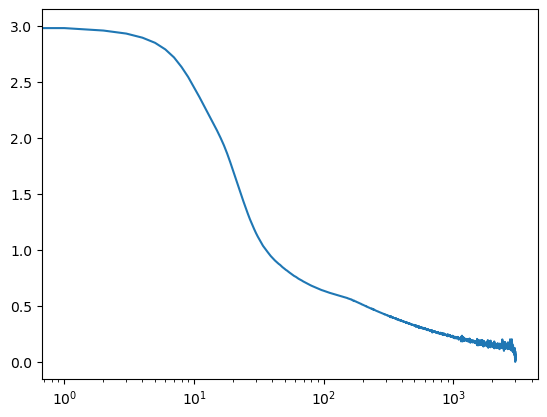

In [46]:
plt.xscale('log')
plt.plot(losses)
plt.show()



In [19]:
# compute fourier stuff
coefs_T = {f'x{idx}': [] for idx, _ in characteristics}

for t, p in solver.checkpoints:
    fouriers = []
    key, subkey = jax.random.split(key)
    t1 = net_vmap(xavg, p, subkey)
    for idx, fn in characteristics:
        t2 = fn(xavg)
        coefs_T[f'x{idx}'].append((t1 * t2).mean())

for a in coefs_T.keys():
    coefs_T[a] = jnp.array(coefs_T[a])

(3000,)

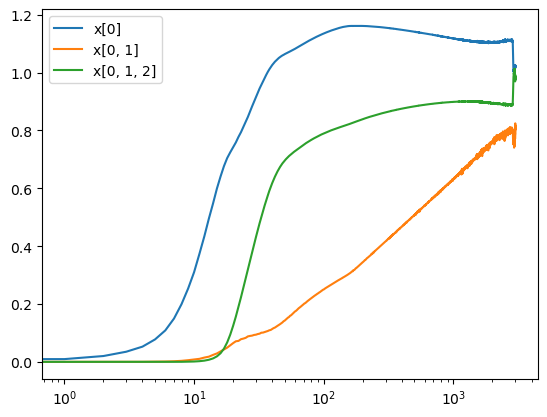

In [28]:
for a, b in coefs_T.items():
    plt.plot(b, label=a)
plt.xscale('log')
plt.legend()
plt.show()

In [27]:
import pickle
out_dir = 'out/merged_staircase'
with open(f"{out_dir}/fourier_pde.pkl", "wb") as f:
    pickle.dump(coefs_T, f)

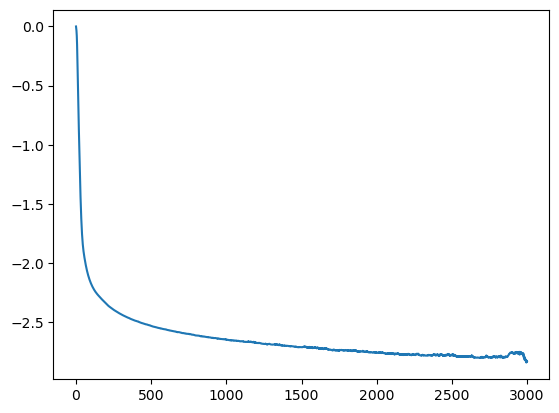

In [38]:
ts = []
Vs = []



for t, p in solver.checkpoints:
    ts.append(t)
    Vs.append(V_vmap(p, subkey).mean())

plt.plot(ts,Vs)
plt.show()